In [9]:
import numpy as np
import matplotlib.pyplot as plt

import torch

from bindsnet.network import Network
from bindsnet.network.nodes import Input, AdaptiveLIFNodes
from bindsnet.network.topology import Connection
from bindsnet.network.monitors import Monitor

def plot_network_activity(inputs, connectivity, voltage, spikes, title=None, sub_titles=["Input spikes", "Feedforward connectivity",
                                                                                         "Voltage", "Spikes"]):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(13, 7))

    h, w = voltage.shape
    ax[0].imshow(inputs)
    ax[0].set_title(sub_titles[0])
    ax[0].set_xlabel("Time [ms]")
    ax[0].set_ylabel("Input neurons")
    ax[0].set_aspect(w / h)
    ax[0].invert_yaxis()

    ax[1].imshow(connectivity)
    ax[1].set_title(sub_titles[1])
    ax[1].set_xlabel("Post")
    ax[1].set_ylabel("Pre") 
    ax[1].invert_yaxis()

    h, w = voltage.shape
    ax[2].imshow(voltage)
    ax[2].set_title(sub_titles[2])
    ax[2].set_xlabel("Time [ms]")
    ax[2].set_ylabel("Neurons")
    ax[2].set_aspect(w / h)
    ax[2].invert_yaxis()

    ax[3].imshow(spikes)
    ax[3].imshow(spikes)
    ax[3].set_title(sub_titles[3])
    ax[3].set_xlabel("Time [ms]")
    ax[3].set_ylabel("Neurons")
    ax[3].set_aspect(w / h)
    ax[3].invert_yaxis()
    
    # change color palette to black and white
    plt.set_cmap('viridis')

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

In [2]:
def connect_one_to_one(n_pre, n_post):
    """
    1 on the main diagonal (i -> i), 0 elsewhere.
    Extra rows/cols stay 0 if sizes differ.
    """
    A = np.zeros((n_pre, n_post), dtype=np.float32)
    np.fill_diagonal(A, 1)
    return A

def connect_all_to_all(n_pre, n_post, exclude_self=True):
    """
    All ones. If square and exclude_self=True, zero the diagonal.
    """
    A = np.ones((n_pre, n_post), dtype=np.float32)
    if exclude_self and n_pre == n_post:
        np.fill_diagonal(A, 0)
    return A

def connect_random(n_pre, n_post, p=0.1, exclude_self=True):
    """
    Each edge present with prob p (independent).
    """
    A = (np.random.rand(n_pre, n_post) < p).astype(np.float32)
    if exclude_self and n_pre == n_post:
        np.fill_diagonal(A, 0)
    return A

def connect_distance(n_neurons, _, sigma=3.0, p_max=0.5, circular=False, exclude_self=True):
    """
    Distance-dependent binary connectivity (1D).
    - Neurons are placed on a 1D line with indices 0..n-1.
    - Connection prob decays with distance: p_ij = p_max * exp(-(d_ij^2)/(2*sigma^2))
    - If circular=True, distance wraps around (ring topology).

    Computes:
        A   : [n, n] binary adjacency (0/1)
        P   : [n, n] connection probabilities used
        D   : [n, n] pairwise distances
        
    Returns:
        A   : [n, n] binary adjacency (0/1)
    """
    idx = np.arange(n_neurons)
    D = np.abs(idx[:, None] - idx[None, :])  # |i-j|
    if circular:
        D = np.minimum(D, n_neurons - D)     # wrap-around distance on a ring

    # Pprobabilities decay exponentially with distance
    P = p_max * np.exp(-(D**2) / (2.0 * sigma**2))

    # Sample connections
    A = (np.random.rand(n_neurons, n_neurons) < P).astype(np.float32)

    if exclude_self:
        np.fill_diagonal(A, 0)
        P[np.diag_indices(n_neurons)] = 0.0

    return A

In [3]:
def poisson_input(
    T, n_neurons, dt,
    target_idx,
    target_rate,
    bg_rate,
    batch_size=1
):
    """
    Generate Poisson spike trains in numpy.

    Args:
        T             : number of time steps
        n_neurons     : number of neurons
        dt            : timestep (ms)
        target_idx    : list of target neuron indices
        target_rate   : firing rate for target neurons (Hz)
        bg_rate       : firing rate for all other neurons (Hz)
        batch_size    : number of batches

    Returns:
        spikes : NumPy array [T, batch_size, n_neurons] of 0/1
    """
    # baseline rates
    rates = np.full(n_neurons, bg_rate, dtype=np.float32)
    rates[np.array(target_idx, dtype=int)] = target_rate

    # probability per step
    p = rates * (dt / 1000.0)  # Hz × s
    p = np.clip(p, 0.0, 1.0)

    # sample
    rand = np.random.rand(T, batch_size, n_neurons)
    spikes = (rand < p).astype(np.float32)
    return spikes

In [4]:
def connect_clustered(n_neurons, n_clusters = None, cluster_size= None,p_in=0.8, p_out=0.01, exclude_self=True):
    """
    Args:
        n_neurons               : number of neurons
        n_clusters              : number of clusters
        cluster_size            : size of each cluster
        p_in                    : connection probability inside a cluster
        p_out                   : connection probability outside a cluster
        exclude_self            : if True, no self-connections (0 on diagonal)
    """
    
    if n_clusters is None:
        n_clusters = n_neurons // 10
    if cluster_size is None:
        cluster_size = n_neurons // n_clusters
    
    
    A = np.zeros((n_neurons, n_neurons), dtype=np.float32) # initialize adjacency matrix with zeros
    
    #cluster_centers = np.linspace(0, n_neurons, n_clusters, endpoint=False, dtype=int) # cluster centers evenly spaced
    
    # cluster centers randomly spaced
    cluster_centers = np.random.choice(np.arange(n_neurons), size=n_clusters, replace=False)
    
    
    # for each cluster, connect neurons inside the cluster with prob p_in, and outside with prob p_out. 
    # probability of connection decays with distance from cluster center
    for center in cluster_centers:
        size = cluster_size
        start = max(0, center - size // 2) # ensure start is non-negative
        end = min(n_neurons, center + size // 2) # ensure end does not exceed n_neurons
        for i in range(start, end): # iterate over neurons in the cluster 
            for j in range(n_neurons): # iterate over all neurons
                if start <= j < end:
                     # connect with prob p_in multiplied by a distance factor
                    distance = abs(i - center)
                    distance_factor = np.exp(- (distance ** 2) / (2 * (cluster_size / 2) ** 2))
                    if np.random.rand() < p_in * distance_factor:
                        A[i, j] = np.random.rand()
                else:
                    if np.random.rand() < p_out:
                        A[i, j] = np.random.rand()
    if exclude_self:
        np.fill_diagonal(A, 0)

    return A

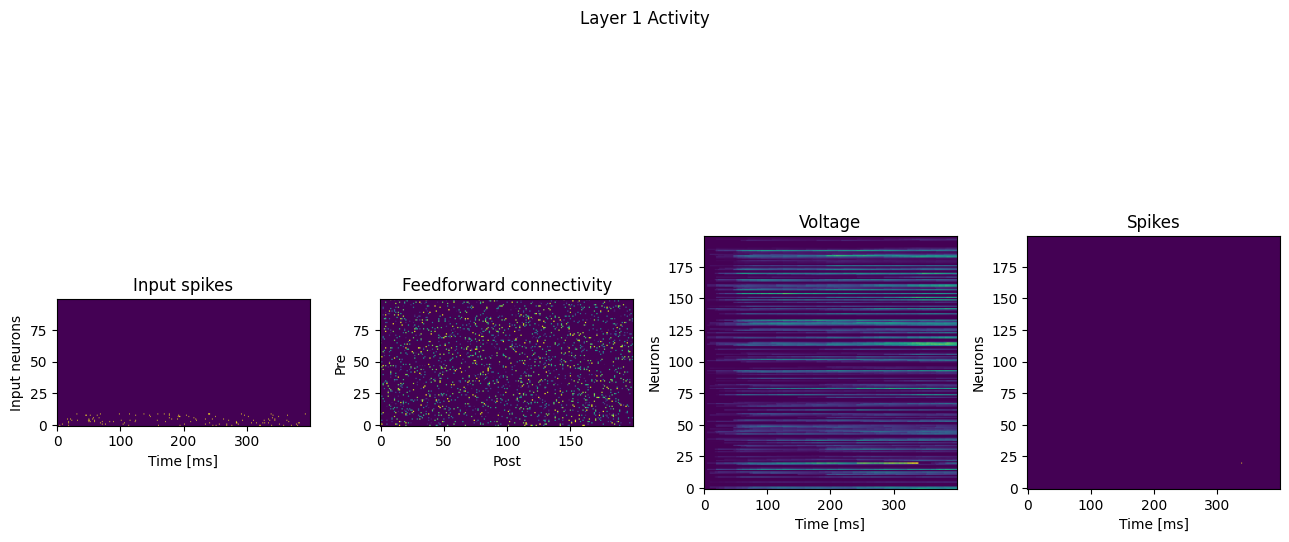

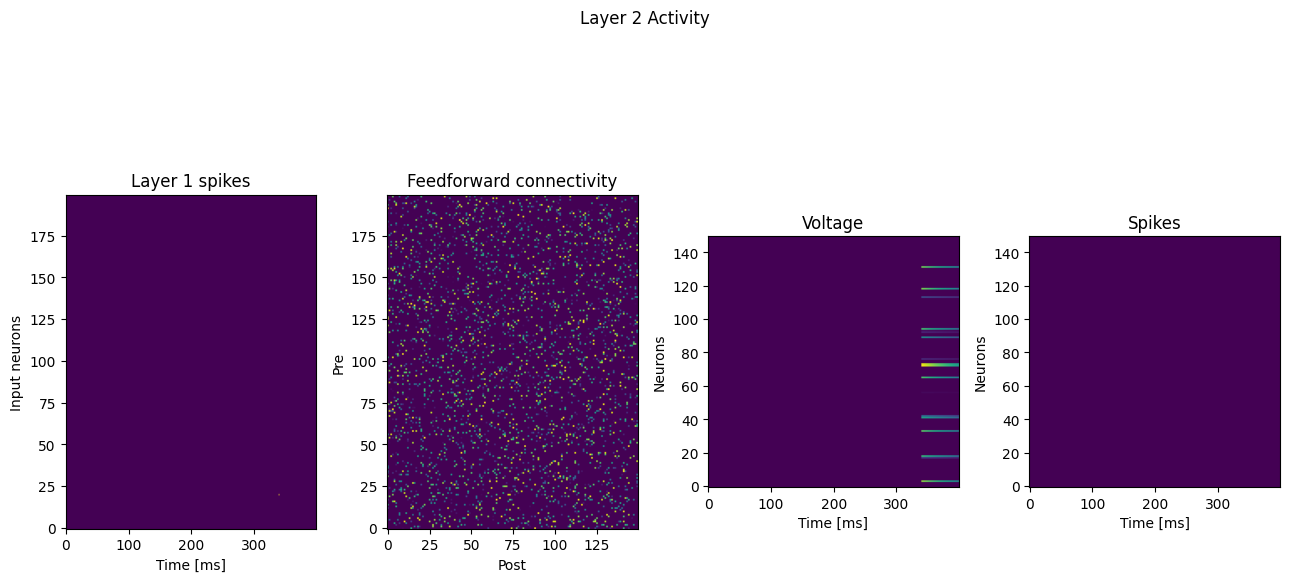

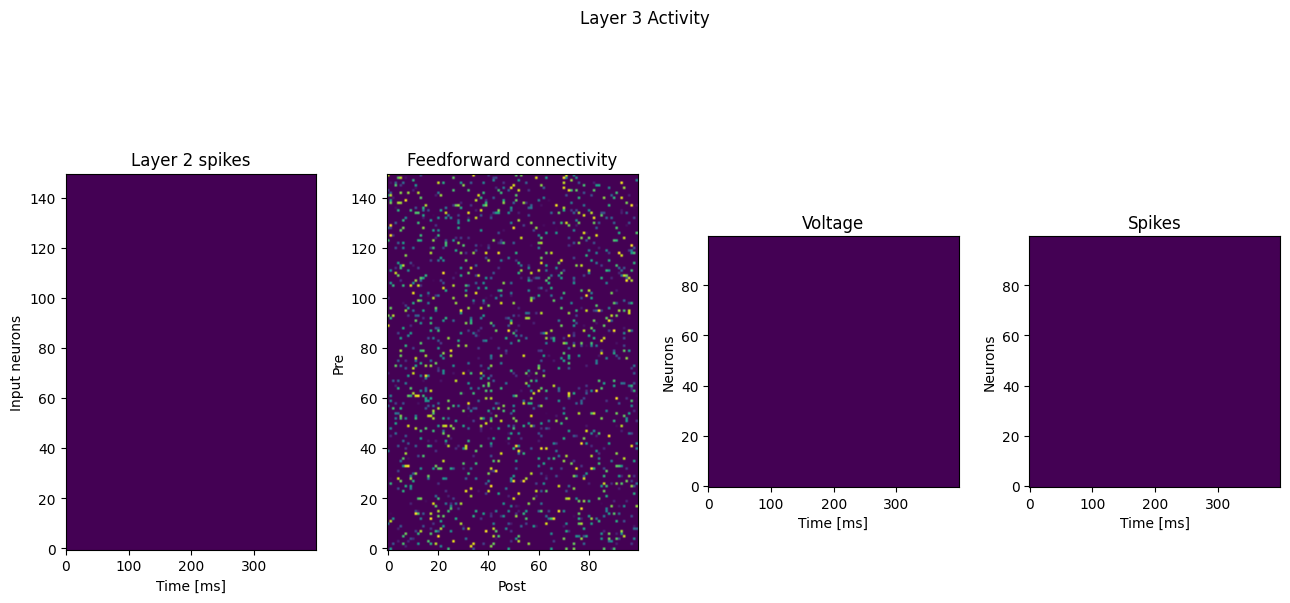

In [ ]:
# Params
n_inputs   = 100
n_neurons  = 200
n_neurons2 = 150
n_neurons3 = 100
dt         = 1.0
sim_length = 400
T          = int(sim_length / dt)

# Stimulate a group of neurons
target_idx  = np.arange(10)
target_rate = 30.0
bg_rate     = 0.0

poisson_spikes = poisson_input(
    T, n_inputs, dt,
    target_idx,
    target_rate,
    bg_rate,
    batch_size=1)
    
I_ext = torch.from_numpy(poisson_spikes)  

# Network
net = Network(dt=dt)

inp    = Input(n=n_inputs)                 # spike source
adlif1 = AdaptiveLIFNodes(n=n_neurons)      # spiking layer
adlif2 = AdaptiveLIFNodes(n=n_neurons2)      # spiking layer
adlif3 = AdaptiveLIFNodes(n=n_neurons3)      # spiking layer


net.add_layer(inp, name="Input")
net.add_layer(adlif1, name="AdLIF 1")
net.add_layer(adlif2, name="AdLIF 2")
net.add_layer(adlif3, name="AdLIF 3")

# Build feedforward connectivity
connections_ff = connect_random(n_inputs, n_neurons)
weights_ff     = np.random.rand(n_inputs, n_neurons).astype(np.float32)
w_ff           = torch.from_numpy(connections_ff * weights_ff)
net.add_connection(Connection(source=inp, target=adlif1, w=w_ff), source="Input", target="AdLIF 1")

# Build feedforward connectivity 2
connections_ff2 = connect_random(n_neurons, n_neurons2)
weights_ff2     = np.random.rand(n_neurons, n_neurons2).astype(np.float32)
w_ff2           = torch.from_numpy(connections_ff2 * weights_ff2)
net.add_connection(Connection(source=adlif1, target=adlif2, w=w_ff2), source="AdLIF 1", target="AdLIF 2")

# Build feedforward connectivity 3
connections_ff3 = connect_random(n_neurons2, n_neurons3)
weights_ff3     = np.random.rand(n_neurons2, n_neurons3).astype(np.float32)
w_ff3 = torch.from_numpy(connections_ff3 * weights_ff3)
net.add_connection(Connection(source=adlif2, target=adlif3, w=w_ff3), source="AdLIF 2", target="AdLIF 3")

# Build lateral connectivity
connections_lat = connect_random(n_neurons, n_neurons)
weights_lat    = connect_clustered(n_neurons)
w_lat           = torch.from_numpy(connections_lat * weights_lat)
net.add_connection(Connection(source=adlif1, target=adlif1, w=w_lat), source="AdLIF 1", target="AdLIF 1")

# Build lateral connectivity 2
connections_lat2 = connect_random(n_neurons2, n_neurons2)
weights_lat2    = connect_clustered(n_neurons2)
w_lat2           = torch.from_numpy(connections_lat2 * weights_lat2)
net.add_connection(Connection(source=adlif2, target=adlif2, w=w_lat2), source="AdLIF 2", target="AdLIF 2")

# Buidlateral connectivity 3
connections_lat3 = connect_random(n_neurons3, n_neurons3)
weights_lat3    = connect_clustered(n_neurons3)
w_lat3           = torch.from_numpy(connections_lat3 * weights_lat3)
net.add_connection(Connection(source=adlif3, target=adlif3, w=w_lat3), source="AdLIF 3", target="AdLIF 3")

# monitors for all layers
mon_s1 = Monitor(net.layers["AdLIF 1"], ["s"], time=T)
mon_v1 = Monitor(net.layers["AdLIF 1"], ["v"], time=T)
net.add_monitor(mon_s1, name="s1")
net.add_monitor(mon_v1, name="v1")
mon_s2 = Monitor(net.layers["AdLIF 2"], ["s"], time=T)
mon_v2 = Monitor(net.layers["AdLIF 2"], ["v"], time=T)
net.add_monitor(mon_s2, name="s2")
net.add_monitor(mon_v2, name="v2")
mon_s3 = Monitor(net.layers["AdLIF 3"], ["s"], time=T)
mon_v3 = Monitor(net.layers["AdLIF 3"], ["v"], time=T)
net.add_monitor(mon_s3, name="s3")
net.add_monitor(mon_v3, name="v3")

# Run with Poisson spikes into the Input layer 
net.run(inputs={"Input": I_ext}, time=T)

s1 = mon_s1.get("s").squeeze(1)  # [T, n_neurons]
v1 = mon_v1.get("v").squeeze(1)  # [T, n_neurons]
s2 = mon_s2.get("s").squeeze(1)  # [T, n_neurons2]
v2 = mon_v2.get("v").squeeze(1)  # [T, n_neurons2]
s3 = mon_s3.get("s").squeeze(1)  # [T, n_neurons3]
v3 = mon_v3.get("v").squeeze(1)  # [T, n_neurons3]

# Spike indices
spike_idx1 = s1.nonzero(as_tuple=False)
spike_idx2 = s2.nonzero(as_tuple=False)
spike_idx3 = s3.nonzero(as_tuple=False)

# plot all layers and lateral connections
plot_network_activity(poisson_spikes.squeeze(1).T, w_ff, v1.T, s1.T, title="Layer 1 Activity", sub_titles=["Input spikes", "Feedforward connectivity",
                                                                                         "Voltage", "Spikes"])
plot_network_activity(s1.T.numpy(), w_ff2, v2.T, s2.T, title="Layer 2 Activity", sub_titles=["Layer 1 spikes", "Feedforward connectivity",
                                                                                         "Voltage", "Spikes"])
plot_network_activity(s2.T.numpy(), w_ff3, v3.T, s3.T, title="Layer 3 Activity", sub_titles=["Layer 2 spikes", "Feedforward connectivity",
                                                                                          "Voltage", "Spikes"])
